# Capstone 2: Correlating Wikipedia traffic with news events
### Jonas Cuadrado

## Introduction

Motivate correlating data from different sources to be able to predict when to allocate extra resources to a server.

This in reality can be extrapolated to almost anything; in fact, I can do it for how the stock market reacts to certain events...


## Part 1a: Extracting traffic data

The Wikipedia project provides open access to all its data, including traffic information. There is hourly traffic data, daily aggregates, and the most viewed pages per day. Here, we want to locate skipes large enough to be considered 'unusual' or 'extraordinary', so that we isolate an article and look for events nearby.

The hourly data is not immediately available through the API, so we'll go ahead with the daily aggregates. We could go to 
https://dumps.wikimedia.org/other/pageviews/,to extract the data, but it takes too long to run.

For the aggregated data, we can use the commands described on https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews

In [1]:
import requests
import json
import pandas as pd
from datetime import datetime
import gzip
import io
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
maindf = pd.DataFrame()
response = requests.get('https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2015/12/31')
maindf = pd.DataFrame(json.loads(response.content.decode('utf-8'))['items'][0]['articles'])
maindf = maindf.set_index('article')
viewsdf=pd.DataFrame()
ranksdf=pd.DataFrame()
viewsdf['2015/12/31'] = maindf['views']
ranksdf['2015/12/31'] = maindf['rank']

# iterate
mainreq = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/'
for year in ['2016','2017']:
    for month in range(1,13): # typically to 13
        if month in [1,3,5,7,8,10,12]:
            # there's 31 days
            for day in range(1,32):
                # get request and do the things
                
                response = requests.get(mainreq+str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                if not (response.status_code==200):
                    print('Oops something went wrong for ' + str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                dftemp = pd.DataFrame(json.loads(response.content.decode('utf-8'))['items'][0]['articles'])
                # change a couple of things for the merging...
                dftemp = dftemp.set_index('article')
                dftemp = dftemp.rename(columns={'views': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                viewsdf = viewsdf.join(dftemp.drop(columns=['rank']), how='outer')
                dftemp = dftemp.drop(columns=[str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')])
                dftemp = dftemp.rename(columns={'rank': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                ranksdf = ranksdf.join(dftemp, how='outer')
        if month in [4,6,9,11]:
            # there's 30 days
            for day in range(1,31):
                # get request and do the things
                response = requests.get(mainreq+str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                if not (response.status_code==200):
                    print('Oops something went wrong for ' + str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                dftemp = pd.DataFrame(json.loads(response.content.decode('utf-8'))['items'][0]['articles'])
                # change a couple of things for the merging...
                dftemp = dftemp.set_index('article')
                dftemp = dftemp.rename(columns={'views': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                viewsdf = viewsdf.join(dftemp.drop(columns=['rank']), how='outer')
                dftemp = dftemp.drop(columns=[str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')])
                dftemp = dftemp.rename(columns={'rank': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                ranksdf = ranksdf.join(dftemp, how='outer')
        if month == 2:
            # there's 28 days
            for day in range(1,29):
                # get request and do the things
                response = requests.get(mainreq+str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                if not (response.status_code==200):
                    print('Oops something went wrong for ' + str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0'))
                dftemp = pd.DataFrame(json.loads(response.content.decode('utf-8'))['items'][0]['articles'])
                # change a couple of things for the merging...
                dftemp = dftemp.set_index('article')
                dftemp = dftemp.rename(columns={'views': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                viewsdf = viewsdf.join(dftemp.drop(columns=['rank']), how='outer')
                dftemp = dftemp.drop(columns=[str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')])
                dftemp = dftemp.rename(columns={'rank': str(year)+'/'+str(month).rjust(2, '0')+'/'+str(day).rjust(2, '0')})
                ranksdf = ranksdf.join(dftemp, how='outer')
        # now maindf should have the data with the right labels and all...
        print('Month '+str(month).rjust(2, '0')+' done')       

# reformat the stuff to work okay from now on       
viewsdf = viewsdf.T
viewsdf.index = pd.to_datetime(viewsdf.index)

Month 01 done
Month 02 done
Month 03 done
Month 04 done
Month 05 done
Month 06 done
Month 07 done
Month 08 done
Month 09 done
Month 10 done
Month 11 done
Month 12 done
Month 01 done
Month 02 done
Month 03 done
Month 04 done
Month 05 done
Month 06 done
Month 07 done
Month 08 done
Month 09 done
Month 10 done
Month 11 done
Month 12 done


In [3]:
# select peaks and plot
# I want to change this so I return a dictionary with date and title... key: date, to make sure there are no duplicates

def peaksplotselection(views,baselineviews=1,threshold= 500000):
    leglist = {}
    vdch = views.fillna(baselineviews).pct_change()
    vdch['MaxPctChange']=vdch.max(axis=1)
    vdch['Art_maxpctch']=vdch.idxmax(axis=1)
    #print(viewsdf.loc[vdch['MaxPctChange'].sort_values(ascending=False).index].head(15))
    for rowidx in range(1,vdch['MaxPctChange'].size):
        # ignore the first one because is a nan    
        colname = vdch.iloc[rowidx]['Art_maxpctch']
        if views.iloc[rowidx][colname] >= threshold:
            valstopl = views.iloc[max(rowidx-5,0):min(rowidx+5,vdch['MaxPctChange'].size-1)][colname].dropna()
            sns.lineplot(data=valstopl)
            leglist[views.index[rowidx]] = colname
    #
    #plt.yscale('log')
    plt.legend(list(leglist.values())[0:7])
    plt.xticks(rotation = 45, ha="right")
    plt.show()
    return(leglist)

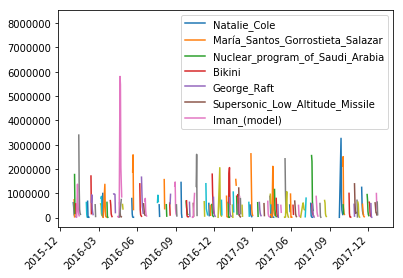

In [4]:
# once the data is extracted, I want to extract the peaks and select them articles
# assume 1 when no views data is available. That's wrong, but it'll give us a consistent measure of the increase
# to look for how this affects the selection, we can make it with 1k views and 10k views

artlist1 = peaksplotselection(views=viewsdf,baselineviews=1,threshold= 500000)

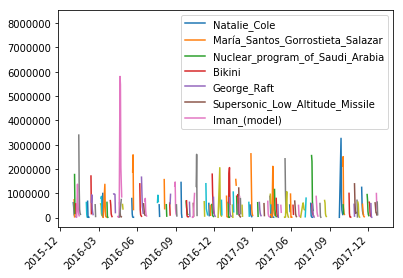

In [5]:
artlist1k = peaksplotselection(views=viewsdf,baselineviews=1000,threshold= 500000)

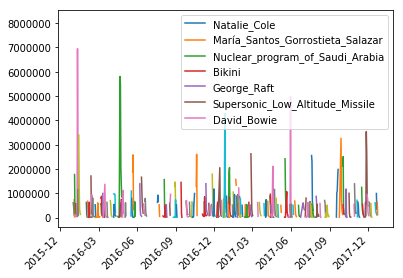

In [6]:
artlist10k = peaksplotselection(views=viewsdf,baselineviews=10000,threshold= 500000)

In [7]:
# how can we compare these lists? they should be in order already... so item by item, find if they are different

# the 10k list has many more articles than the other 2...
print('Is there no difference between baseline 1 and 1000?', 
        len(list(artlist1.values()))==len(list(artlist1k.values())) and all(list(artlist1.values()).count(i)==list(artlist1k.values()).count(i) for i in list(artlist1.values())))

print('How many articles on baseline 1 are not on baseline 10.000?', sum(i not in list(artlist10k.values()) for i in list(artlist1.values())))
print()
# Find the differences!
print('Article not in b10k:', list(i for i in list(artlist1.values()) if i not in list(artlist10k.values())))
print()
print('Articles not in b1:', list(i for i in list(artlist10k.values()) if i not in list(artlist1.values())))

Is there no difference between baseline 1 and 1000? True
How many articles on baseline 1 are not on baseline 10.000? 1

Article not in b10k: ['Iman_(model)']

Articles not in b1: ['David_Bowie', 'Charles_Perrault', 'Pat_Bowlen', 'Alexander_Hamilton', 'Keanu_Reeves', 'Genie_(feral_child)', 'Rogue_One', 'Electronic_System_for_Travel_Authorization', 'Hertha_Marks_Ayrton', 'Jane_Jacobs', '404.php', 'Frankie_Manning', 'Harry_Potter', 'Elizabeth_I_of_England', 'MS_The_World', 'Meghan_Markle', 'Jagadish_Chandra_Bose', 'John_Glenn', "'Tis_the_Season", 'George_Michael', 'Chelsea_Manning', 'Bessie_Coleman', 'Sally_Yates', 'Chance_the_Rapper', 'Alexander_Hamilton', 'Fazlur_Rahman_Khan', 'Wikipedia:Contact_us', 'Gilbert_Baker_(artist)', 'Aaron_Judge', 'Jodie_Whittaker', 'Laverne_Cox', 'Joe_Arpaio', 'Fridtjof_Nansen', 'Direct_and_indirect_realism', 'Meghan_Markle']


In [19]:
# Now we want to select those from the list this most views, and list the top 15 (say)
print('Articles with most views')
print(viewsdf[list(artlist10k.values())].max(axis=0).sort_values(ascending=False).head(15))
print()
print('Articles with least views')
print(viewsdf[list(artlist10k.values())].max(axis=0).sort_values(ascending=False).tail(15))

Articles with most views
article
Charles_Darwin                                              8145795.0
David_Bowie                                                 6948182.0
404.php                                                     6190956.0
Prince_(musician)                                           5808147.0
Wikipedia:Contact_us                                        4977887.0
Government_Secure_Intranet                                  4293586.0
George_Michael                                              4275899.0
Meghan_Markle                                               3536755.0
Meghan_Markle                                               3536755.0
Alan_Rickman                                                3394010.0
Hugh_Hefner                                                 3261496.0
Bill_Paxton                                                 2622501.0
Anterior_interventricular_branch_of_left_coronary_artery    2601855.0
Azúcar_Moreno                                            

There is not a big difference, so I will select the largest list: baseline 10k. This is because the peaks seem to be higher as well. Ideally we could look for the 65k articles and fill in the nan's with the actual data. 

## Part 1b: Extracting Wikipedia articles

Now, we need to take the articles selected above and obtain their contents, and save them to perform topci modelling later with other articles from a news dataset

In [20]:
# next, we want to see how we extract a full article from the wiki.

def extractwikiart(articlenamelist):
    """articlenamelist needs to be a list of strings callable to the wikipedia page"""
    listofarts = []
    for articlename in articlenamelist:
        bo = requests.get('https://en.wikipedia.org/wiki/'+articlename+'?action=raw')
        if bo.status_code!=200:
            print('Error obtaining the article')
            listofarts.append('')
        else:
            f = io.BytesIO(bo.content)
            strart = f.read().decode('UTF-8')
            # celaning this: remove non alphanumeric, remove '\n'
            strart = strart.replace('\n', ' ')
            strart = re.sub('[^0-9a-zA-Z]+', ' ', strart)
            listofarts.append(strart)
    return(listofarts)

print(extractwikiart(['Barack_Obama']))
print(extractwikiart(['Bk_Oba)']))

[' Redirect2 Barack Obama other uses Barack disambiguation and Obama disambiguation Pp move indef Pp semi small yes short description 44th President of the United States Active editnotice Use American English date August 2018 Use mdy dates date June 2018 Infobox president image President Barack Obama jpg alt Obama standing with his arms folded and smiling order 44th office President of the United States vicepresident Joe Biden term start January 20 2009 term end January 20 2017 predecessor George W Bush successor Donald Trump jr sr1 United States Senator state1 Illinois term start1 January 3 2005 term end1 November 16 2008 predecessor1 Peter Fitzgerald politician Peter Fitzgerald successor1 Roland Burris state senate2 Illinois district2 13th predecessor2 Alice Palmer politician Alice Palmer term start2 January 8 1997 term end2 November 4 2004 successor2 Kwame Raoul birth name Barack Hussein Obama II birth date birth date and age 1961 8 4 birth place Honolulu Hawaii United States U S pa

Error obtaining the article
['']


In [21]:
df1 = pd.DataFrame.from_dict(artlist10k,orient='index')
df1=df1.reset_index()
df1=df1.rename(index=str, columns={'index':'date', 0: "title"})
df1['publication'] = 'Wikipedia'
df1['content'] = extractwikiart(df1['title'])
df1.head()

Error obtaining the article


One article failed! Which one? 

In [22]:
df1[df1['content']=='']

In [23]:
df1 = df1.drop('135')
print(df1[df1['content']==''])
df1 = df1.reset_index()

Empty DataFrame
Columns: [date, title, publication, content]
Index: []


In [24]:
df1.head()

I want to save this now for later analysis

In [25]:
df1.to_csv('Wikipediaarticles.csv')